### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
iris_data = pd.read_csv('iris.csv').drop('Id', axis=1)
iris_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Train Test Split

In [3]:
def train_test_split(data, class_column, train_size = 40):
    classes = data[class_column].unique()
    test, train = pd.DataFrame(), pd.DataFrame()
    for c in classes:
        currentClass = data[data[class_column] == c]
        test = pd.concat([test, currentClass.iloc[train_size:, :]], ignore_index=True)
        train = pd.concat([train, currentClass.iloc[:train_size, :]], ignore_index=True)
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    return train_X, train_y, test_X, test_y

In [4]:
train_X, train_y, test_X, test_y = train_test_split(iris_data, 'Species', 40)
print(train_X)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0              5.1           3.5            1.4           0.2
1              4.9           3.0            1.4           0.2
2              4.7           3.2            1.3           0.2
3              4.6           3.1            1.5           0.2
4              5.0           3.6            1.4           0.2
..             ...           ...            ...           ...
115            7.7           3.0            6.1           2.3
116            6.3           3.4            5.6           2.4
117            6.4           3.1            5.5           1.8
118            6.0           3.0            4.8           1.8
119            6.9           3.1            5.4           2.1

[120 rows x 4 columns]


### Bayes Classifier

In [5]:
#function to find covariance matrix
def covariance_matrix(data):
    mean_vector = np.mean(data, axis=0)
    z_matrix = data - mean_vector
    cov_matrix = np.dot(z_matrix.T, z_matrix) / (data.shape[0] - 1)
    return cov_matrix

In [6]:
def fit_bayes_classifier(train_X, train_y):
    classes = np.unique(train_y)
    cov_mats, cov_dets = {}, {}
    inv_cov_mats = {}
    mean_vectors = {}
    apriori = {}
    for c in classes:
        apriori[c] = len(train_y[train_y == c]) / len(train_y)
        mean_vectors[c] = np.array(train_X[train_y == c].mean())
        cov_mats[c] = covariance_matrix(np.array(train_X[train_y == c]))
        cov_dets[c] = np.linalg.det(cov_mats[c])
        inv_cov_mats[c] = np.linalg.inv(cov_mats[c])
    return cov_dets, inv_cov_mats, apriori, mean_vectors

def predict(apriori, mean_vectors, cov_dets, inv_cov_mats, train_X, train_y, test_point):
    classes = np.unique(train_y)
    dimensions = train_X.shape[1]
    class_probabilities = {}

    for c in classes:
        req_vector = np.array(test_point) - mean_vectors[c]
        numerator = np.exp(-0.5 * np.dot(np.dot(req_vector.T, inv_cov_mats[c]), req_vector))
        denominator = np.power(2 * np.pi, dimensions / 2) * np.power(cov_dets[c], 0.5)
        class_probabilities[c] = apriori[c] * (numerator / denominator)

    cl = max(zip(class_probabilities.values(), class_probabilities.keys()))[1]
    for i in range(len(classes)):
        if classes[i] == cl:
            return i

def discriminant_function(apriori, mean_vectors, cov_dets, inv_cov_mats, train_X, train_y, test_point):
    classes = np.unique(train_y)
    dimensions = train_X.shape[1]
    class_probabilities = {}

    for c in classes:
        req_vector = np.array(test_point) - mean_vectors[c]
        numerator = np.exp(-0.5 * np.dot(np.dot(req_vector.T, inv_cov_mats[c]), req_vector))
        denominator = np.power(2 * np.pi, dimensions / 2) * np.power(cov_dets[c], 0.5)
        class_probabilities[c] = apriori[c] * (numerator / denominator)

    return max(class_probabilities.values())

In [7]:
cov_dets, inv_cov_mats, aprioris, mean_vectors = fit_bayes_classifier(train_X.iloc[:, 2:], train_y)

### Plotting

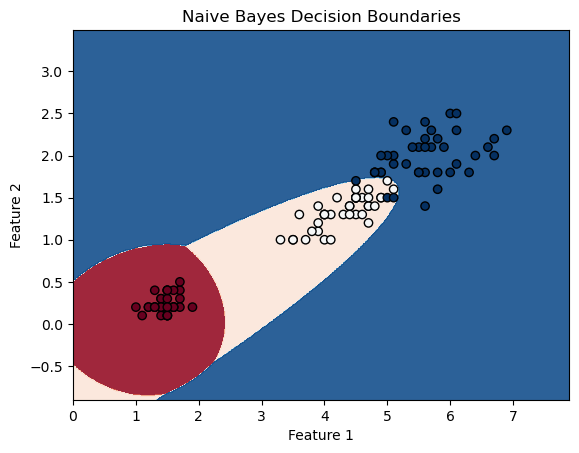

In [8]:
x_min, x_max = train_X.iloc[:, 2].min() - 1, train_X.iloc[:, 2].max() + 1
y_min, y_max = train_X.iloc[:, 3].min() - 1, train_X.iloc[:, 3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
z = []
for i in range(xx.shape[0]):
    for j in range(yy.shape[1]):
        z.append(predict(aprioris, mean_vectors, cov_dets, inv_cov_mats, train_X.iloc[:, 2:], train_y, [xx[i][j], yy[i][j]]))
z = np.array(z)
Z = z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha = 0.9)
train_yy = np.zeros_like(train_y)
classes = np.unique(train_y)
for i in range(len(classes)):
    train_yy[train_y == classes[i]] = i
plt.scatter(train_X.iloc[:, 2], train_X.iloc[:, 3], c = train_yy, cmap = plt.cm.RdBu, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Naive Bayes Decision Boundaries')
plt.show()

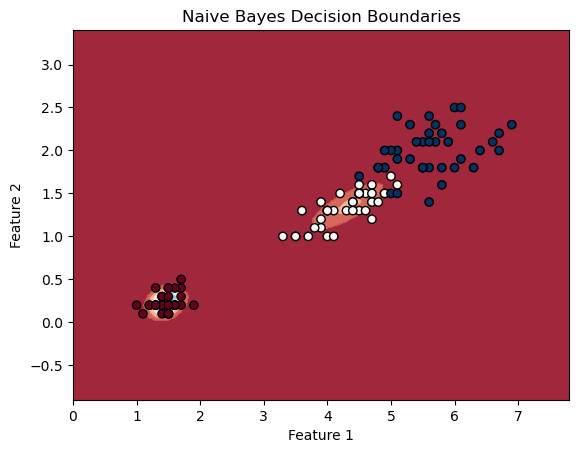

In [10]:
x_min, x_max = train_X.iloc[:, 2].min() - 1, train_X.iloc[:, 2].max() + 1
y_min, y_max = train_X.iloc[:, 3].min() - 1, train_X.iloc[:, 3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
z1 = []
for i in range(xx.shape[0]):
    for j in range(yy.shape[1]):
        z1.append(discriminant_function(aprioris, mean_vectors, cov_dets, inv_cov_mats, train_X.iloc[:, 2:], train_y, [xx[i][j], yy[i][j]]))
z1 = np.array(z1)
Z1 = z1.reshape(xx.shape)

plt.contourf(xx, yy, Z1, cmap=plt.cm.RdBu, alpha = 0.9)
train_yy = np.zeros_like(train_y)
classes = np.unique(train_y)
for i in range(len(classes)):
    train_yy[train_y == classes[i]] = i
plt.scatter(train_X.iloc[:, 2], train_X.iloc[:, 3], c = train_yy, cmap = plt.cm.RdBu, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Naive Bayes Decision Boundaries')
plt.show()